In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from icevision.all import *

################################################################################
### WARNING, path does not exist: KALDI_ROOT=/mnt/matylda5/iveselyk/Tools/kaldi-trunk
###          (please add 'export KALDI_ROOT=<your_path>' in your $HOME/.profile)
###          (or run as: KALDI_ROOT=<your_path> python <your_script>.py)
################################################################################

/home/ppotrykus/anaconda3/envs/icevision-asr/lib/python3.8/site-packages/torchaudio/backend/utils.py:53: UserWarning: "sox" backend is being deprecated. The default backend will be changed to "sox_io" backend in 0.8.0 and "sox" backend will be removed in 0.9.0. Please migrate to "sox_io" backend. Please refer to https://github.com/pytorch/audio/issues/903 for the detail.
  warnings.warn(
[NeMo W 2021-04-14 12:38:31 experimental:27] Module <class 'nemo.collections.asr.data.audio_to_text.AudioToCharDataset'> is experimental, not ready for production and is not fully supported. Use at your own

## Define hyperparams

In [3]:
batch_size = 32
num_workers = 4
labels = [
    "bed", "bird", "cat", "dog", "down", "eight", "five", "four", "go", "happy", "house", "left",
    "marvin", "nine", "no", "off", "on", "one", "right", "seven", "sheila", "six", "stop", "three",
    "tree", "two", "up", "wow", "yes", "zero"
]

## Download dataset

In [19]:
# edit this line if you want to store it elsewhere
dataset_dir = Path.home()/'.icevision/data/google_speech_commands'
dataset_dir.mkdir(exist_ok=True)

train_manifest = dataset_dir/'train_manifest.json'
validation_manifest = dataset_dir/'validation_manifest.json'

In [72]:
download_and_extract(
    url='http://download.tensorflow.org/data/speech_commands_v0.01.tar.gz',
    save_path=dataset_dir/'speech_commands_v0.01.tar.gz'
)

  0%|          | 0/1489096277 [00:00<?, ?B/s]

In [73]:
download_url(url='http://transfer.sh/TT18d/train_manifest.json', save_path=train_manifest)

  0%|          | 0/4416847 [00:00<?, ?B/s]

In [74]:
download_url(url='http://transfer.sh/7d3AT/validation_manifest.json', save_path=validation_manifest)

  0%|          | 0/587434 [00:00<?, ?B/s]

## Create parsers and records

In [5]:
# background is set to None cause there is no negative samples in nemo pretrained model
class_map = ClassMap(labels, background=None)

In [6]:
train_parser = parsers.NemoSpeechCommandsParser(
    image_dir=dataset_dir,
    manifest_filepath=train_manifest, 
    class_map=class_map
)
valid_parser = parsers.NemoSpeechCommandsParser(
    image_dir=dataset_dir,
    manifest_filepath=validation_manifest, 
    class_map=class_map
)

In [7]:
train_records, *_ = train_parser.parse(SingleSplitSplitter(), autofix=False)
valid_records, *_ = valid_parser.parse(SingleSplitSplitter(), autofix=False)

0it [00:00, ?it/s]

0it [00:00, ?it/s]

## Explore records

In [8]:
first(train_records)

BaseRecord

common: 
	- Image ID: 0
	- Image size None
	- Audio duration [s]: 0.0
	- Filepath: /home/ppotrykus/.icevision/data/google_speech_commands/six/36050ef3_nohash_4.wav
classification: 
	- Class Map: <ClassMap: {'bed': 0, 'bird': 1, 'cat': 2, 'dog': 3, 'down': 4, 'eight': 5, 'five': 6, 'four': 7, 'go': 8, 'happy': 9, 'house': 10, 'left': 11, 'marvin': 12, 'nine': 13, 'no': 14, 'off': 15, 'on': 16, 'one': 17, 'right': 18, 'seven': 19, 'sheila': 20, 'six': 21, 'stop': 22, 'three': 23, 'tree': 24, 'two': 25, 'up': 26, 'wow': 27, 'yes': 28, 'zero': 29}>
	- Labels: [21]

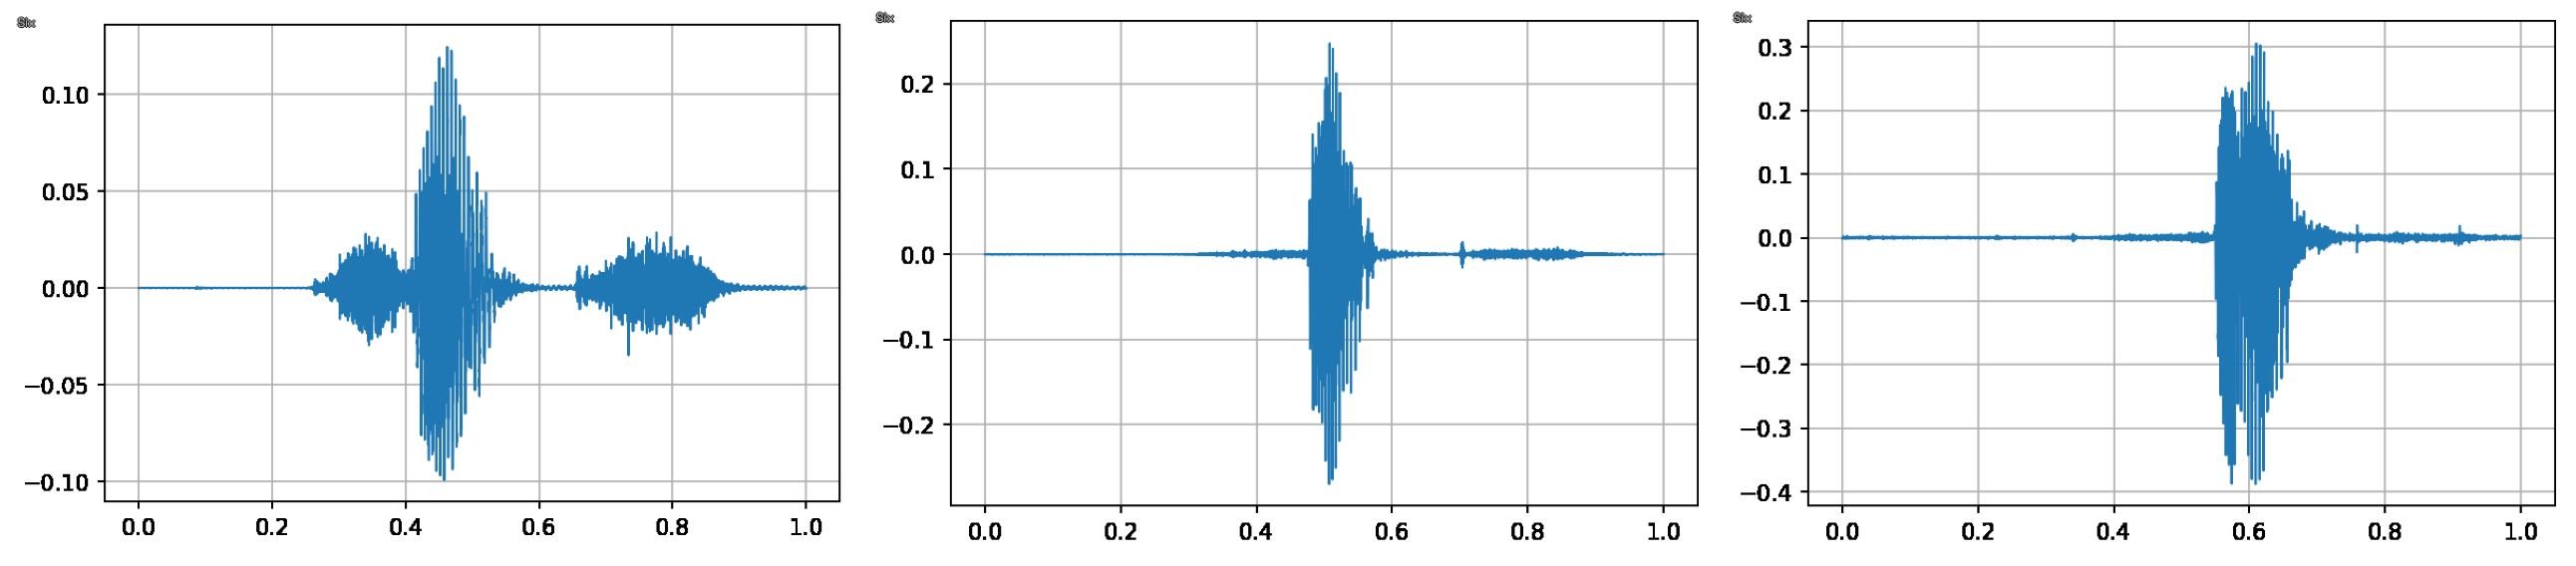

In [9]:
show_records(train_records[:3], ncols=3, class_map=class_map)

In [10]:
train_ds = Dataset(train_records, tfm=None)
valid_ds = Dataset(valid_records, tfm=None)

In [11]:
train_dl = nvidia_nemo.train_dl(train_ds, shuffle=True, batch_size=batch_size, num_workers=num_workers)
valid_dl = nvidia_nemo.valid_dl(valid_ds, shuffle=False, batch_size=batch_size, num_workers=num_workers)

## Explore batch

In [12]:
batch = first(train_dl)

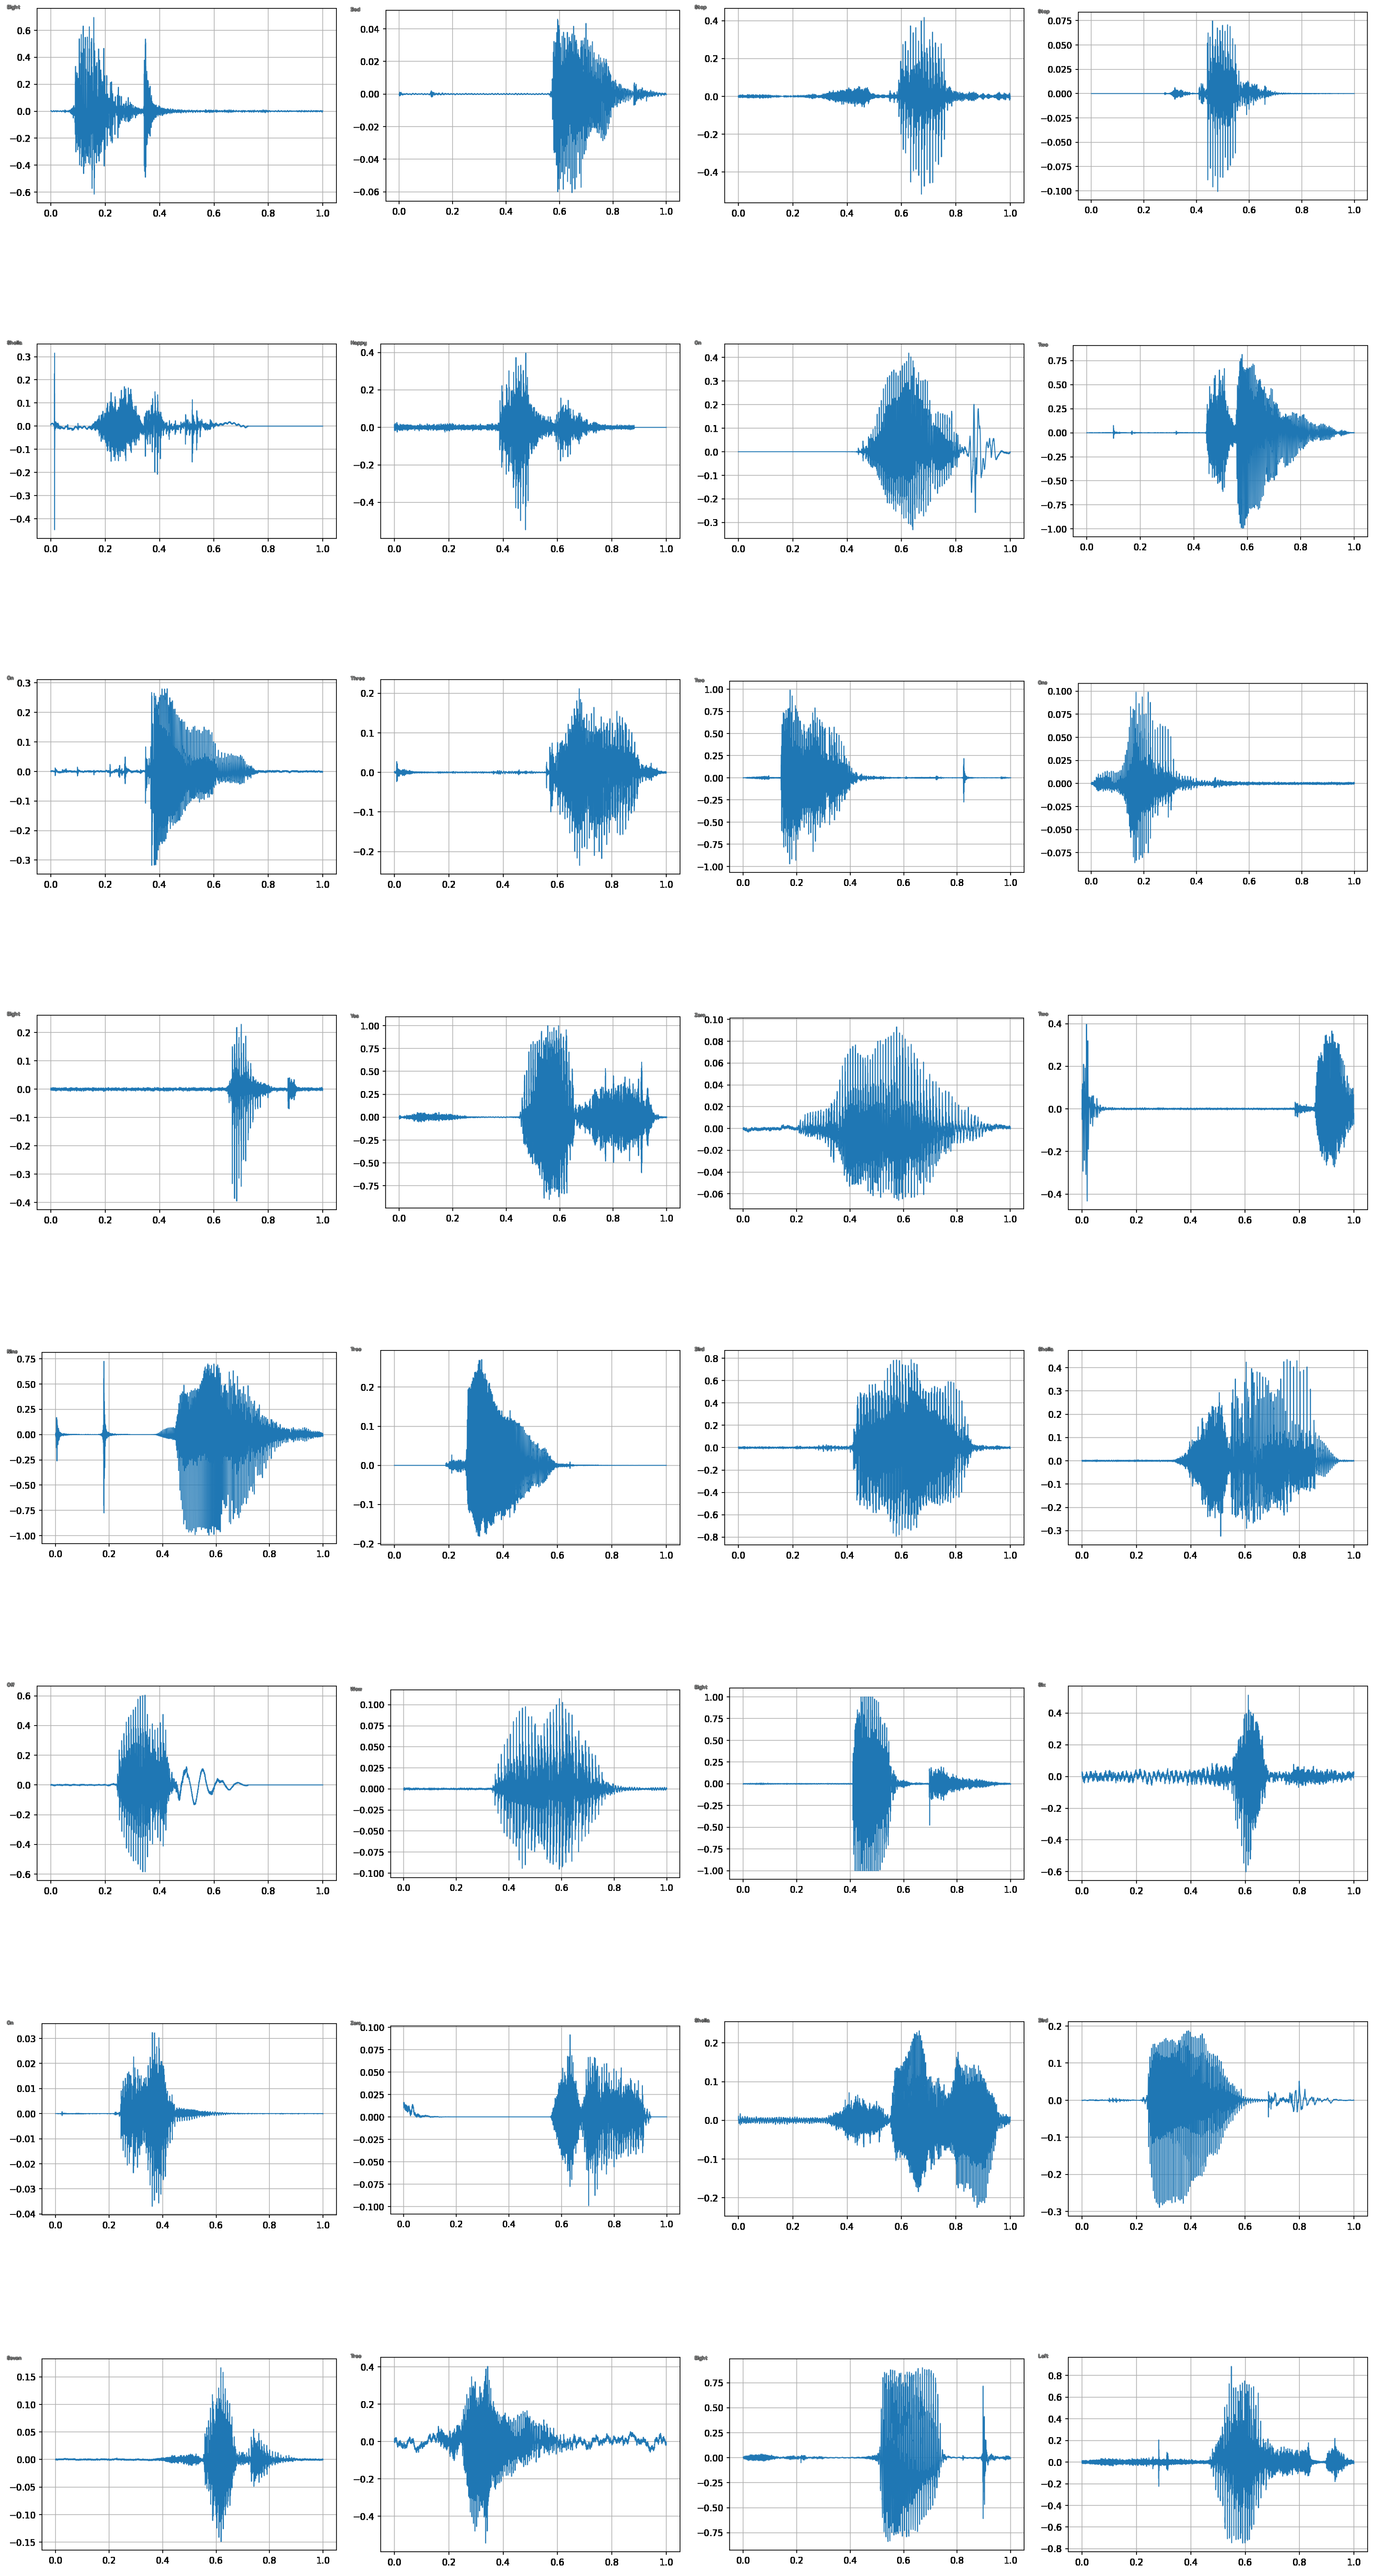

In [13]:
nvidia_nemo.show_batch(batch, ncols=4)

## Create nemo pretrained model

You can check the available nemo pretrained models with

In [14]:
nvidia_nemo.list_available_models()

[PretrainedModelInfo(pretrained_model_name='MatchboxNet-3x1x64-v1', description='MatchboxNet model trained on Google Speech Commands dataset (v1, 30 classes) which obtains 97.32% accuracy on test set.', location='https://api.ngc.nvidia.com/v2/models/nvidia/nemospeechmodels/versions/1.0.0a5/files/MatchboxNet-3x1x64-v1.nemo', class_=None),
 PretrainedModelInfo(pretrained_model_name='MatchboxNet-3x2x64-v1', description='MatchboxNet model trained on Google Speech Commands dataset (v1, 30 classes) which obtains 97.68% accuracy on test set.', location='https://api.ngc.nvidia.com/v2/models/nvidia/nemospeechmodels/versions/1.0.0a5/files/MatchboxNet-3x2x64-v1.nemo', class_=None),
 PretrainedModelInfo(pretrained_model_name='MatchboxNet-3x1x64-v2', description='MatchboxNet model trained on Google Speech Commands dataset (v2, 35 classes) which obtains 97.12% accuracy on test set.', location='https://api.ngc.nvidia.com/v2/models/nvidia/nemospeechmodels/versions/1.0.0a5/files/MatchboxNet-3x1x64-v2.n

Note that v1 is the 30 commands dataset so we should use only those pretrained models to laverage transfer learning on google speech command dataset

In [15]:
model = nvidia_nemo.model(
    model_name="MatchboxNet-3x1x64-v1", 
    num_classes=class_map.num_classes, 
    pretrained=True
)

# Pytorch lightning

In [16]:
class LightModel(nvidia_nemo.lightning.ModelAdapter):
    def configure_optimizers(self):
        return SGD(self.parameters(), lr=0.05)

light_model = LightModel(model=model)

## Create trainer

In [17]:
trainer = pl.Trainer(
    gpus=1,
    max_epochs=2,
)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


## Test
Lets see if out loaded pretrained model is truly accurate

In [18]:
trainer.test(light_model, valid_dl)

Testing: 0it [00:00, ?it/s]

[NeMo W 2021-04-14 12:39:50 nemo_logging:349] /home/ppotrykus/anaconda3/envs/icevision-asr/lib/python3.8/site-packages/torch/functional.py:515: UserWarning: stft will require the return_complex parameter be explicitly  specified in a future PyTorch release. Use return_complex=False  to preserve the current behavior or return_complex=True to return  a complex output. (Triggered internally at  /pytorch/aten/src/ATen/native/SpectralOps.cpp:653.)
      return _VF.stft(input, n_fft, hop_length, win_length, window,  # type: ignore
    
[NeMo W 2021-04-14 12:39:50 nemo_logging:349] /home/ppotrykus/anaconda3/envs/icevision-asr/lib/python3.8/site-packages/torch/functional.py:515: UserWarning: The function torch.rfft is deprecated and will be removed in a future PyTorch release. Use the new torch.fft module functions, instead, by importing torch.fft and calling torch.fft.fft or torch.fft.rfft. (Triggered internally at  /pytorch/aten/src/ATen/native/SpectralOps.cpp:590.)
      return _VF.stft(inp

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_accuracy': tensor(0.9675, device='cuda:0'),
 'test_loss': tensor(0.1155, device='cuda:0')}
--------------------------------------------------------------------------------


[{'test_loss': 0.11553215980529785, 'test_accuracy': 0.9674904346466064}]

## Fit

In [57]:
trainer.fit(light_model, train_dl, valid_dl)


  | Name                | Type         | Params
-----------------------------------------------------
0 | model               | ModelWrapper | 77.2 K
1 | validation_accuracy | Accuracy     | 0     
2 | training_accuracy   | Accuracy     | 0     


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

1

# Fastai

In [58]:
from fastai.metrics import accuracy

In [59]:
learner = nvidia_nemo.learner(dls=(train_dl, valid_dl), model=model, metrics=[accuracy])

SuggestedLRs(lr_min=4.365158383734525e-06, lr_steep=1.5848931980144698e-06)

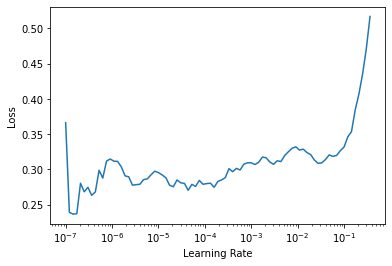

In [60]:
learner.freeze()
learner.lr_find()

In [63]:
learner.fine_tune(2, 0.03, 3)

epoch,train_loss,valid_loss,accuracy,time
0,0.308237,0.143576,0.959547,01:01
1,0.371930,0.159317,0.959253,01:06
2,0.406074,0.166424,0.958811,01:05


epoch,train_loss,valid_loss,accuracy,time
0,0.314738,0.136373,0.964254,01:00
1,0.292820,0.121207,0.968961,01:04
